# **TAMIL WORD-LEVEL TEXT CLASSIFICATION**

## Importing the requirements

In [8]:
# For Data Analysis and Manipulation
import pandas as pd
import numpy as np

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sb
from prettytable import PrettyTable

# For Model Building
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import VotingClassifier

# For Analyzing Model's performance
from sklearn.metrics import accuracy_score, \
                            f1_score, \
                            classification_report, \
                            precision_score, \
                            recall_score

## Data Collection

### Reading all the given data

In [9]:
kanada_data = pd.read_csv("kn_train.csv")
kanada_val = pd.read_csv("kn_val.csv")
kanada_data = pd.concat([kanada_data, kanada_val], axis=0)

tamil_data = pd.read_csv("tamil_train.csv")
tamil_val = pd.read_csv("tamil_val.csv")
tamil_data = pd.concat([tamil_data, tamil_val], axis=0)

tulu_data = pd.read_csv("tulu_train.csv")
tulu_val = pd.read_csv("tulu_val.csv")
tulu_data = pd.concat([tulu_data, tulu_val], axis=0)

malayalam_data = pd.read_csv("mal_train.csv")
malayalam_val = pd.read_csv("mal_val.csv")
malayalam_data = pd.concat([malayalam_data, malayalam_val], axis=0)

### Removing unwanted data and Oversampling for specific categories

In [10]:
# Few wrong data in the "sym" category
tamil_data = tamil_data[~((tamil_data["Tag"] == "sym") & (tamil_data["Word"] != "*"))].replace("*", "asterisk").fillna("")

# Oversampling "en", "other", "mixed" categories to improve accuracy of those categories
tamil_en = tamil_data[tamil_data["Tag"] == "en"]
tamil_other = tamil_data[tamil_data["Tag"] == "Other"]
tamil_mixed = tamil_data[tamil_data["Tag"] == "tmen"]

# Names from other languages are also included (More the data, Better the performance)
tamil_name = tamil_data[tamil_data["Tag"] == "name"]
kanada_name = kanada_data[kanada_data["Tag"] == "name"]
tulu_name = tulu_data[tulu_data["Language"] == "Name"]
tulu_name.columns = ["Word", "Tag"]
tulu_name["Tag"] = tulu_name["Tag"].replace("Name", "name")
malayalam_name = malayalam_data[malayalam_data["Tag"] == "NAME"]
malayalam_name["Tag"] = malayalam_name["Tag"].replace("NAME", "name")

# Locations from other languages are also included
tamil_loc = tamil_data[tamil_data["Tag"] == "Location"]
kanada_loc = kanada_data[kanada_data["Tag"] == "location"]
kanada_loc["Tag"] = kanada_loc["Tag"].replace("location", "Location")
tulu_loc = tulu_data[tulu_data["Language"] == "Location"]
tulu_loc.columns = ["Word", "Tag"]
malayalam_loc = malayalam_data[malayalam_data["Tag"] == "PLACE"]
malayalam_loc["Tag"] = malayalam_loc["Tag"].replace("PLACE", "Location")

# Combining all the data needed for training
tamil_data = pd.concat([tamil_data, tamil_other, tamil_en, tamil_mixed, tamil_other, kanada_loc, tamil_other, kanada_name, tamil_other, tulu_name, tamil_mixed, tamil_name, tulu_loc, tamil_loc, tamil_other, malayalam_loc, malayalam_name])

# Removing some unknown Tag present in the given dataset 
tamil_data["Tag"] = np.where(tamil_data["Tag"].isin(["tm", "en", "tmen", "sym", "name", "Other", "Location"]), tamil_data["Tag"], "Other")

C:\Users\justa\AppData\Local\Temp\ipykernel_9432\53615739.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tulu_name["Tag"] = tulu_name["Tag"].replace("Name", "name")
C:\Users\justa\AppData\Local\Temp\ipykernel_9432\53615739.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malayalam_name["Tag"] = malayalam_name["Tag"].replace("NAME", "name")
C:\Users\justa\AppData\Local\Temp\ipykernel_9432\53615739.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

## Data Visualization

In [11]:
tamil_data["Tag"].value_counts()

Tag
tm          8064
name        7745
en          6518
tmen        4197
sym         1309
Location     839
Other        489
Name: count, dtype: int64

In [12]:
tamil_data["Tag"].describe()

count     29161
unique        7
top          tm
freq       8064
Name: Tag, dtype: object

<Axes: xlabel='Tag', ylabel='Count'>

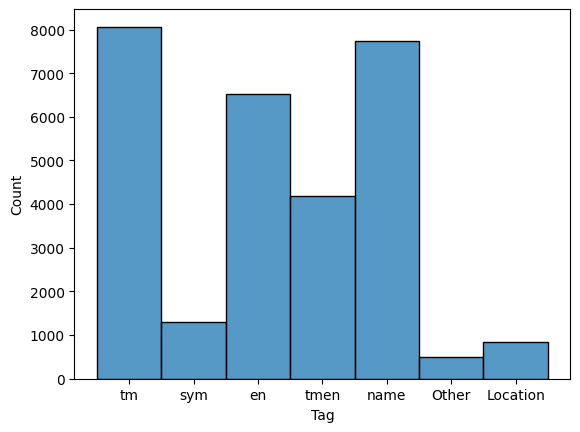

In [13]:
sb.histplot(tamil_data["Tag"])

## ML Model Analysis

### Model and Vector Initialization

In [24]:
# Using Character Level Count Vectorizer to extract features from each Word
countVectorizer = CountVectorizer(ngram_range=(1,5), analyzer='char')

# Used for analysis of each model
kf = KFold(n_splits=10, shuffle=True, random_state=42)


model1 = DecisionTreeClassifier(random_state=42)

model2 = LogisticRegression(solver='newton-cg', max_iter=2000)

model3 = svm.SVC()

model7 = VotingClassifier(
    estimators=[
        ('dtc', model1), 
        ('lr', model2), 
        ('svm', model3),
    ],
    voting='hard'
)


acc = [[], [], []] 
f1 = [[], [], []]
pre = [[], [], []]
rec = [[], [], []]

f1_a = [[], [], []]

### Training of the Models

In [25]:
# X,Y of the Training data
X = tamil_data["Word"]
Y = tamil_data["Tag"]


for train_index, test_index in kf.split(X):
    # Segregating the train and test data for this iteration
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Vectorizing the Word
    train_vect_count = countVectorizer.fit_transform(X_train)
    test_vect_count = countVectorizer.transform(X_test)

    # DECISION TREE CLASSIFIER MODEL
    model1.fit(train_vect_count, y_train)
    model1_predict = model1.predict(test_vect_count)

    acc[0].append(accuracy_score(y_test, model1_predict))
    f1[0].append(f1_score(y_test, model1_predict, average='macro'))
    f1_a[0].append(f1_score(y_test, model1_predict, average='weighted'))
    pre[0].append(precision_score(y_test, model1_predict, average='macro', zero_division=np.nan))
    rec[0].append(recall_score(y_test, model1_predict, average='macro', zero_division=np.nan))


    # LOGISTIC REGRESSION MODEL
    model2.fit(train_vect_count, y_train)
    model2_predict = model2.predict(test_vect_count)

    acc[1].append(accuracy_score(y_test, model2_predict))
    f1[1].append(f1_score(y_test, model2_predict, average='macro'))
    f1_a[1].append(f1_score(y_test, model2_predict, average='weighted'))
    pre[1].append(precision_score(y_test, model2_predict, average="macro", zero_division=np.nan))
    rec[1].append(recall_score(y_test, model2_predict, average="macro", zero_division=np.nan))

    # SUPPORT VECTOR MACHINE MODEL
    model3.fit(train_vect_count, y_train)
    model3_predict = model3.predict(test_vect_count)

    acc[2].append(accuracy_score(y_test, model3_predict))
    f1[2].append(f1_score(y_test, model3_predict, average="macro"))
    f1_a[2].append(f1_score(y_test, model3_predict, average="weighted"))
    pre[2].append(precision_score(y_test, model3_predict, average="macro", zero_division=np.nan))
    rec[2].append(recall_score(y_test, model3_predict, average="macro", zero_division=np.nan))

### Score analysis of each Model

In [26]:
DTC = ["Decision Tree Classifier",sum(acc[0])/len(acc[0]), sum(f1[0])/len(f1[0]), sum(f1_a[0])/len(f1_a[0]),sum(pre[0])/len(pre[0]), sum(rec[0])/len(rec[0])]
Logistic = ["Logistic Regression", sum(acc[1])/len(acc[1]), sum(f1[1])/len(f1[1]), sum(f1_a[1])/len(f1_a[1]), sum(pre[1])/len(pre[1]), sum(rec[1])/len(rec[1])]
SVM = ["Support Vector Machine",sum(acc[2])/len(acc[2]), sum(f1[2])/len(f1[2]), sum(f1_a[2])/len(f1_a[2]), sum(pre[2])/len(pre[2]), sum(rec[2])/len(rec[2])]

fields = ["Model Name", "Accuracy", "F1 Score (Macro)", "F1 Score (Weighted)", "Precision", "Recall Score"]

table = PrettyTable(field_names=fields)
table.add_rows([DTC, Logistic, SVM])
table

Model Name,Accuracy,F1 Score (Macro),F1 Score (Weighted),Precision,Recall Score
Decision Tree Classifier,0.9235622807128921,0.9207967845296935,0.923197287100783,0.9140878146385492,0.9289657124749731
Logistic Regression,0.9374848988451878,0.934104558149507,0.9373220752178112,0.9324733946938488,0.9368028195401938
Support Vector Machine,0.9232536857633672,0.9133870387577682,0.9229353984307156,0.9243395434946248,0.906087542871138


## Model Training and Prediction

In [27]:
# Initializing the Training and Test data
x_train = tamil_data["Word"]
y_train = tamil_data["Tag"]
final_test = pd.read_csv("Tamil_Test_Set_No_Labels.csv")
x_test = final_test["Word"].replace("*", "asterisk").fillna("")

# Vectorizing the Words
count_vec_train = countVectorizer.fit_transform(x_train)
count_vec_test = countVectorizer.transform(x_test)

# Fitting the Training Data in the Model
model7.fit(count_vec_train, y_train)
# Predicting the Test Data
pred = model7.predict(count_vec_test)

# Converting the Predictions back to CSV file
result = pd.concat([final_test.reset_index(drop=True), pd.Series(pred, name="Tag")], axis=1)
result.to_csv('predictions.csv', index=False)

## Overview of Prediction

In [28]:
ans = pd.read_csv("predictions.csv")
ans["Tag"].value_counts()

Tag
tm          953
en          547
sym         204
tmen        149
name        140
Location     16
Other        15
Name: count, dtype: int64